# Homework 3

#### EE-556 Mathematics of Data - Fall 2024

In this homework we will solve constrained optimization problems.

#### Setup

<div class="alert alert-danger">
    <b>Warning</b> You will need a couple of libraries for this homework, which you can install with pip by executing the block below.
</div>

In [1]:
!pip install -r requirements.txt

zsh:1: command not found: pip


# 1. Constrained optimization - 40 points

In [2]:
from lib.part1.deblur_lib import *
from scipy.sparse.linalg import svds

#### Introduction

We have seen in the lectures that given an optimization task whose iterates live on a  convex subset $\mathcal{X} \subset \mathbb{R}^n$ we can ensure the iterates of our algorithms stay within $\mathcal{X}$ in one of two ways. 

In the first way, we use projections, computed via the proximal operator $\text{prox}_{\delta_\mathcal{X}}$. In the second way, we use linear minimization oracles  $\text{lmo}_\mathcal{X}$ within a conditional gradient framework
that take simplicial combinations of elements from the set X whereby producing iterates remaining in $\mathcal{X}$.

The following exercises will help you understand what kind of computations are involved for each of these two operators, and how their computational complexity compares. For this we will work with $\mathcal{X}$ being the set of low-rank matrices defined via the nuclear norm ball $\mathcal{X}=\lbrace X:X\in \mathbb{R}^{p\times n}, \Vert X  \Vert_* \leq \xi \rbrace$ with $\xi$ being the radius of the zero-centered nuclear norm ball.

We will first mathematically study properties of  the proximal operator $\text{prox}_{\delta_\mathcal{X}}$  (**1.1** ) and the linear minimization oracles $\text{lmo}_\mathcal{X}$ (**1.2**) onto this $\mathcal{X}$ and then compare them empirically by implementing movie recommender system (**1.3**) and image deblurring (**1.4**) algorithms.




## 1.1 Computing projections onto $\mathcal{X}$ - 10 points


#### Question 1.1.1 (2 pts)

Recall that given a set $\mathcal{X} \subset \mathbb{R}^{p \times m}$, its corresponding
    projection operator is given by
    $\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z}) = \mathop{\mathrm{arg\,min}}\limits_{{\bf X}\in \mathcal{X}}\{ \|{\bf X}- \boldsymbol{Z}\|_F^2\}, \; \forall \boldsymbol{Z}\in  \mathbb{R}^{p \times m}$.
    Using the definition of the proximal operator given in class, show
    the equivalence between the projection operator and the proximal
    operator:
    $$\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z})  = \mathrm{prox}_{\delta_{\mathcal{X}}}(\boldsymbol{Z}),$$
    where $\delta_{\mathcal{X}}$ is the indicator function of
    $\mathcal{X}$ i.e.  $\delta_{\mathcal{X}}({\bf Y}) = \begin{cases} 0, \text{ if } {\bf Y}\in \mathcal{X} \\ +\infty, \text{ o.w. } \end{cases}$

<font color="blue">

We have the definition of proximal operator
 $$
    \mathrm{prox}_f(\mathbf{X}) := \arg\min_{\mathbf{Z} \in \mathbb{R}^{p\times m}} \left\{ f(\mathbf{Z}) + \frac{1}{2} \|\mathbf{Z} - \mathbf{X}\|_F^2 \right\}.
    $$

The presence of $+\infty$ for $\mathbf{Y} \notin \mathcal{X}$ (because of $\delta$) restricts the minimization in proximal operator to $\mathbf{Y} \in \mathcal{X}$
$$
= \arg\min_{\mathbf{Y} \in \mathcal{X}} \frac{1}{2} \|\mathbf{Y} - \mathbf{Z}\|_F^2.
$$

This is exactly the definition of the projection operator $\mathrm{proj}_{\mathcal{X}} (\mathbf{Z})$, as we do not care about the multiplier $1/2$ when seeking the $\arg\min$,
$$
\mathrm{prox}_{\delta_{\mathcal{X}}}(\mathbf{Z}) = \mathrm{proj}_{\mathcal{X}} (\mathbf{Z}).
$$

#### Question 1.1.2 (4 pts)

Moreau’s identity is a fundamental equality for $\mathrm{prox}$:
$$\begin{align}
        \mathrm{prox}_{f} (\textbf{x}) + \mathrm{prox}_{f^*} (\textbf{x}) = \textbf{x}, \forall \textbf{x} \in \mathbb{R}^p.\label{eq:Moreau}\tag{1}
\end{align}$$

Use Moreau’s identity to find the proximal operator of $\|\mathbf{x} \|_\infty$ and $\|\mathbf{x} \|_2$.

(Hint: For $f(\mathbf{x})=\|\mathbf{x}\|_p$ with $p\geq 1$, then $f^*(\mathbf{x})=\delta_{\|\mathbf{x}\|_q \leq 1}(\mathbf{x})$ where $\frac{1}{p}+\frac{1}{q}=1$.)

<font color="blue">

For $ p = \infty $ we have $ q = 1 $. Therefore:
$$
f^*(\mathbf{x}) = \delta_{\|\mathbf{x}\|_1 \leq 1}(\mathbf{x}).
$$

Using Moreau's identity:
$$
\mathrm{prox}_{\|\cdot\|_\infty} (\mathbf{x}) = \mathbf{x} - \mathrm{prox}_{\delta_{\|\cdot\|_1 \leq 1}} (\mathbf{x}).
$$

The proximal operator of an indicator function is the projection onto the corresponding set. Therefore:
$$
\mathrm{prox}_{\|\cdot\|_\infty} (\mathbf{x}) = \mathbf{x} - \mathrm{proj}_{\|\cdot\|_1 \leq 1} (\mathbf{x}).
$$

The convex conjugate $ f^* $ for $ f(\mathbf{x}) = \|\mathbf{x}\|_2 $ is:
$$
f^*(\mathbf{x}) = \delta_{\|\mathbf{x}\|_2 \leq 1}(\mathbf{x}),
$$
since the dual norm of the Euclidean norm is itself  ( $ q = 2 $ when $ p = 2 $ ).
We thus have
$$
\mathrm{prox}_{\|\cdot\|_2} (\mathbf{x}) = \mathbf{x} - \mathrm{prox}_{\delta_{\|\cdot\|_2 \leq 1}} (\mathbf{x}).
$$

We need to find the projection onto the $ \ell_2 $ -ball $ \mathcal{B}_2 = \{\mathbf{x} \in \mathbb{R}^p : \|\mathbf{x}\|_2 \leq 1\} $.

We need to solve:

$$
\min_{\mathbf{y}} \|\mathbf{y} - \mathbf{x}\|_2^2 \quad \text{subject to} \quad \|\mathbf{y}\|_2 \leq 1,
$$

for the case when $\mathbf{x}$ has $\|\mathbf{x}\|_2 > 1$.

So set up the Lagrangian:

$$
L(\mathbf{y}, \lambda) = \|\mathbf{y} - \mathbf{x}\|_2^2 + \lambda (\|\mathbf{y}\|_2^2 - 1)
$$

Taking the derivative with respect to $ \mathbf{y} $ and setting it to zero for optimality:

$$
2(\mathbf{y} - \mathbf{x}) + 2\lambda \mathbf{y} = 0 \\
\Rightarrow \mathbf{y} (1 + \lambda) = \mathbf{x} \\
\Rightarrow \mathbf{y} = \frac{\mathbf{x}}{1 + \lambda}
$$

The Lagrange multiplier $ \lambda $ is chosen such that the constraint $ \|\mathbf{y}\|_2 = 1 $ is satisfied, so

$$
\|\mathbf{y}\|_2 = \left\|\frac{\mathbf{x}}{1 + \lambda}\right\|_2 = 1 \\
\Rightarrow \frac{\|\mathbf{x}\|_2}{1 + \lambda} = 1 \\
\Rightarrow 1 + \lambda = \|\mathbf{x}\|_2 \\
\Rightarrow \lambda = \|\mathbf{x}\|_2 - 1
$$

In the end we derive $\mathbf{y}$ value

$$
\mathbf{y} = \frac{\mathbf{x}}{1 + (\|\mathbf{x}\|_2 - 1)} = \frac{\mathbf{x}}{\|\mathbf{x}\|_2}.
$$

Therefore we have
$$
\mathrm{proj}_{\|\cdot\|_2 \leq 1} (\mathbf{x}) =
\begin{cases}
\mathbf{x}, & \text{if } \|\mathbf{x}\|_2 \leq 1, \\
\frac{\mathbf{x}}{\|\mathbf{x}\|_2}, & \text{otherwise}.
\end{cases}
$$

Thus in this case the answer is

$$
\mathrm{prox}_{\|\cdot\|_2} (\mathbf{x}) =
\begin{cases}
\mathbf{0}, & \text{if } \|\mathbf{x}\|_2 \leq 1, \\
\mathbf{x} - \frac{\mathbf{x}}{\|\mathbf{x}\|_2}, & \text{otherwise}.
\end{cases}
$$

#### Question 1.1.3.  (4 pts)

Let ${\boldsymbol Z}= {\boldsymbol U}\boldsymbol{\Sigma} {\boldsymbol V}^\top$
    be the singular value decomposition of
    ${\boldsymbol Z}\in \mathbb{R}^{p \times m}$. Denote the diagonal of
    $\boldsymbol{\Sigma} \in \mathbb{R}^{s \times s}$ by a vector
    $\sigma \in \mathbb{R}^{s}$, where $s = \min \{ p, m \}$. Let
    $\sigma^{\ell_1}$ be the projection of $\sigma$ onto the
    $\ell_1$-norm ball
    $\{ \textbf{x}: \textbf{x}\in \mathbb{R}^{s} , \left\Vert  \textbf{x} \right\Vert_1 \leq \xi  \}$
    with radius $\xi$. Show that the projection of this matrix onto
    the nuclear norm ball
    $\mathcal{X} = \{ {\boldsymbol X}: {\boldsymbol X}\in \mathbb{R}^{p \times m} , \| {\boldsymbol X}\|_\ast \leq \xi \}$
    can be computed by projecting $\sigma$ onto the $\ell_1$ norm ball,
    i.e.,
    $$\mathrm{proj}_\mathcal{X} ({\boldsymbol Z}) = {\boldsymbol U}\boldsymbol\Sigma^{\ell_1} {\boldsymbol V}^\top,$$
    where $\Sigma^{\ell_1} \in \mathbb{R}^{s \times s}$ denotes the
    diagonal matrix with diagonal $\sigma^{\ell_1}$.

(Hint: Use Mirsky's inequality:
    $\| {\boldsymbol X}- {\boldsymbol Z}\|_F \geq \| \boldsymbol{\Sigma}_{{\boldsymbol X}} - \boldsymbol{\Sigma}_{{\boldsymbol Z}}\|_F$,
    where
    $\boldsymbol{\Sigma}_{{\boldsymbol X}}, \boldsymbol{\Sigma}_{{\boldsymbol Z}} \in \mathbb{R}^{s \times s}$
    are the diagonal matrices of the singular values of
    ${\boldsymbol X}, {\boldsymbol Z}$ respectively.)

<font color="blue">

Let 
$$
\mathbf{X}'=\mathbf{U}\boldsymbol{\Sigma}_X\mathbf{V}^\top.
$$
Note that
$$
\|\mathbf{X}'-\mathbf{Z}\|_F = \|\mathbf{U}\boldsymbol{\Sigma}_X\mathbf{V}^\top - \mathbf{U}\boldsymbol{\Sigma}\mathbf{V}^\top\|_F = \|\boldsymbol{\Sigma}_X - \boldsymbol{\Sigma}\|_F.
$$

Since $\|\mathbf{X}-\mathbf{Z}\|_F \geq \|\boldsymbol{\Sigma}_X-\boldsymbol{\Sigma}\|_F$, it follows that 
$$
\|\mathbf{X}'-\mathbf{Z}\|_F \leq \|\mathbf{X}-\mathbf{Z}\|_F.
$$

Moreover, since $\|\mathbf{X}'\|_* = \sum_i \sigma_{X,i} = \|\mathbf{X}\|_*$, the constraint $\|\mathbf{X}\|_*\leq \xi$ also holds for $\mathbf{X}'$. Thus, if $\mathbf{X}$ is an optimal solution, so is $\mathbf{X}'$. Hence, we can assume without loss of generality that the optimal solution shares the same singular vectors as $\mathbf{Z}$:
$$
\mathbf{X}=\mathbf{U}\boldsymbol{\Sigma}_X\mathbf{V}^\top.
$$

Thus the projection problem becomes
$$
\min_{\boldsymbol{\Sigma}_X : \|\boldsymbol{\Sigma}_X\|_*\leq \xi}\|\boldsymbol{\Sigma}_X-\boldsymbol{\Sigma}\|_F,
$$
where $\|\boldsymbol{\Sigma}_X\|_* = \sum_{i=1}^s \sigma_{X,i}\leq \xi$ and $\boldsymbol{\Sigma}_X=\mathrm{diag}(\sigma_{X,1},\ldots,\sigma_{X,s})$.

Since both $\boldsymbol{\Sigma}_X$ and $\boldsymbol{\Sigma}$ are diagonal, this problem reduces to
$$
\min_{\{\sigma_{X,i}\}:\sum_i \sigma_{X,i}\leq \xi}\sum_{i=1}^s(\sigma_{X,i}-\sigma_i)^2,
$$
which is exactly the projection on to the $\ell1$ ball of singular values vector.

We thus have 
$$
\boldsymbol{\Sigma}_X = \mathrm{diag}(\sigma_{X,1}^{\ell_1},\ldots,\sigma_{X,s}^{\ell_1}),
$$
where $(\sigma_{X,i}^{\ell_1})_{i=1}^s$ is the $\ell_1$-projection of $(\sigma_i)_{i=1}^s$, 
and so the original projection onto the nuclear norm ball is
$$
\mathrm{proj}_\mathcal{X}(\mathbf{Z}) = \mathbf{U}\boldsymbol{\Sigma}^{\ell_1}\mathbf{V}^\top.
$$

How about the projection of this matrix onto the spectral norm ball $\mathcal{S} = \{ {\boldsymbol X}: {\boldsymbol X}\in \mathbb{R}^{p \times m} , \| {\boldsymbol X}\|_2 \leq \xi \}$?

<font color="blue">

By similar inequalities we derive that the $\min$ problem can be reduced to 
$$
\min\sum_{i=1}^s (\sigma_{X,i}-\sigma_i)^2,
$$
and since 
$\|X\|_2 = \max_i \sigma_{X,i},$
the constraint 
$\|X\|_2 \leq \xi$
is equivalent to
$$
\sigma_{X,1} \leq \xi \quad \text{and} \quad \sigma_{X,i} \leq \sigma_{X,1} \text{ for all } i.
$$
To minimize this subject within 
$\sigma_{X,1} \leq \xi$
and 
$\sigma_{X,i} \leq \sigma_{X,1},$
we obviously need just to clip the singular values so they are not bigger than $\xi$ and as close to the ones of matrix $Z$.

Thus, the original projection onto the spectral norm ball is given by:
$$
\mathrm{proj}_{\mathcal{S}}(Z) = U \Sigma^{\text{op}} V^\top,
$$
where 
$$
\Sigma^{\text{op}} = \mathrm{diag}(\sigma_1^{\text{op}}, \sigma_2^{\text{op}}, \ldots, \sigma_s^{\text{op}})
$$
and
$$
\sigma_i^{\text{op}} = \min(\sigma_i, \xi) \quad \text{for all } i = 1, 2, \ldots, s.
$$

## 1.2 Computing the linear minimization oracle of $\mathcal{X}$ - 2 points

Problem 1.1 shows that projection onto the nuclear norm ball requires
computing the singular value decomposition. The computational complexity
of the singular value decomposition is $\mathcal{O}(\min(m^2p,mp^2))$,
which can easily become a computational bottleneck if $m$ or $p$ are
large. This bottleneck increased the popularity of algorithms that
leverage the linear minimization oracle (lmo) instead (e.g.,
[Jaggi2013](https://proceedings.mlr.press/v28/jaggi13.html), [yurtsever2018](http://proceedings.mlr.press/v80/yurtsever18a)):
$$\text{lmo}_{\mathcal{X}}({\boldsymbol Z})  = \arg \min_{{\boldsymbol X}\in \mathcal{X}} \langle {\boldsymbol X},{\boldsymbol Z}\rangle \qquad \text{where}\qquad \langle {\boldsymbol X},{\boldsymbol Z}\rangle = \text{Tr}({\boldsymbol Z}^\top{\boldsymbol X}).$$
Note that $\text{lmo}_\mathcal{X}({\boldsymbol Z})$ is not single valued
in general. With abuse of terminology, when we say that we compute the
lmo, we actually mean that we compute an instance ${\boldsymbol X}$ such
that ${\boldsymbol X}\in \text{lmo}_\mathcal{X}({\boldsymbol Z})$.

Show that the lmo$_\mathcal{X}$ when $\mathcal{X}$ is the nuclear norm
ball:
$\mathcal{X} = \{ {\boldsymbol X}: {\boldsymbol X}\in \mathbb{R}^{p \times m} , \| {\boldsymbol X}\|_\ast \leq \xi \}$
gives the following output:
$$-\xi ~ \! \mathbf{u}\mathbf{v}^T   \in  \text{lmo}_{{\mathcal{X}}}({\boldsymbol Z}) ,$$
where $\mathbf{u}$ and $\mathbf{v}$ are the left and right singular
vectors that correspond to the largest singular value of
${\boldsymbol Z}$.

(Hint: By definition
$\xi ~ \! \mathbf{u}\mathbf{v}^T \in \mathcal{X}$. You just need to
show
$\langle {\boldsymbol X},{\boldsymbol Z}\rangle \geq \langle -\xi ~ \! \mathbf{u}\mathbf{v}^T,{\boldsymbol Z}\rangle$
for all ${\boldsymbol X}\in \mathcal{X}$.)

<font color="blue">

Indeed we have that 
$$
\| -\xi \mathbf{u}\mathbf{v}^\top \|_* = \xi \| \mathbf{u}\mathbf{v}^\top \|_* = \xi,
$$
since $\mathbf{u}\mathbf{v}^\top$ has a single non-zero singular value equal to $1$.  
Thus, $-\xi ~ \! \mathbf{u}\mathbf{v}^T \in \mathcal{X}$.

We now see that
$$ \text{Tr}\left(\boldsymbol{Z}^\top (-\xi \mathbf{u}\mathbf{v}^\top)\right) = -\xi \text{Tr}(\boldsymbol{Z}^\top \mathbf{u}\mathbf{v}^\top).
$$
Since 
$$
\boldsymbol{Z} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^\top,
$$
we have:
$$
\boldsymbol{Z}^\top \mathbf{u}\mathbf{v}^\top = \mathbf{V} \boldsymbol{\Sigma} \mathbf{U}^\top \mathbf{u}\mathbf{v}^\top = \mathbf{V} \boldsymbol{\Sigma} \mathbf{e}_1 \mathbf{v}^\top = \sigma_1 \mathbf{v}\mathbf{v}^\top,
$$
where $\mathbf{e}_1$ is the first element of orthonormal basis of the space ($\mathbf{U}$ is orthonormal matrix, and the same is for $\mathbf{V}$).
Therefore:
$$
\langle -\xi \mathbf{u}\mathbf{v}^\top, \boldsymbol{Z} \rangle = -\xi \sigma_1 \text{Tr}(\mathbf{v}\mathbf{v}^\top) = -\xi \sigma_1.
$$
As $\sigma_1$ is the biggest singular value of $Z$, and the norm of $X$ is at most $\xi$, then by Holder inequality we get (as nuclear and spectral norm are dual)
$$
\langle {\boldsymbol X},{\boldsymbol Z}\rangle \geq - \| X\|_*\|Z\|_2 = -\xi\sigma_1,
$$
which shows that $\langle {\boldsymbol X},{\boldsymbol Z}\rangle \geq \langle -\xi ~ \! \mathbf{u}\mathbf{v}^T,{\boldsymbol Z}\rangle$
for all ${\boldsymbol X}\in \mathcal{X}$.

## 1.3 Comparing the scalability of $\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z})$ and $\mathrm{lmo}_{\mathcal{X}} (\boldsymbol{Z})$ - 9 points

In this exercise, we will compare the execution time of
$\mathrm{proj}_{\mathcal{X}} (\boldsymbol{Z})$ and
$\mathrm{lmo}_{\mathcal{X}} (\boldsymbol{Z})$ on two datasets provided
to you in the codes. These datasets consist of the ratings given by
MovieLens users to movies in a given list. The 100k dataset consists of
100,000 ratings from 1000 users on 1700 movies. The 1M dataset consists
of 1 million ratings from 6000 users on 4000 movies.

As you likely figured out already from the numbers above, users do not
rate all of the movies, and therefore, we model the ratings as entries
of a low-rank matrix, where rows correspond to different users and
columns correspond to different movies. A classical task in machine
learning is to predict the value of the missing entries, which is called
the matrix completion problem.

Many other tasks can be formulated as convex minimization problems,
constrained to the nuclear-norm ball, which captures a low rank model
since it is the atomic norm of rank-1 matrices (see Lecture 4). A good
optimization algorithm must ensure feasibility in a scalable way: For
instance, the famous Netflix competition data consists of 100480507
ratings that 480189 users gave to 17770 movies (much bigger than the
datasets above). Projecting a matrix of this size onto the nuclear-norm
ball is indeed demanding.

#### Question 1.3.1 (3 pts)

Implement the projection operator as a function called `proj_nuc` below. You can use the helper function `proj_L1` we define here from the `projL1.py` file.

In [3]:
from lib.part1.projL1 import projL1

Set $\xi = 3000$ and measure the computation time of the
    projection operator with the 100k and the 1M MovieLens dataset using our provided helper code, which loads the datasets, constructs the data matrix, and times the evaluation of
    the projection operator. Write the values you get in a markdown cell.
    Run and report the average timing.

In [4]:
def proj_nuc(Z, xi):
    """ This function implements the projection onto the nuclear norm ball.
    """
    U, S, V = np.linalg.svd(Z, full_matrices=False)
    S_xi = projL1(S, xi)
    Z_xi = U @ np.diag(S_xi) @ V
    return Z_xi

In [5]:
eval_completion("100k_MovieLens", proj_nuc, xi=3000)

100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

proj for ./lib/part1/dataset/ml-100k/ub_base data takes 0.96238751411438 sec


In [6]:
# NOTE: This one can take few minutes!
eval_completion("1M_MovieLens", proj_nuc, xi=3000)

100%|██████████| 5/5 [02:53<00:00, 34.73s/it]

proj for ./lib/part1/dataset/ml-1m/ml1m_base data takes 34.72389116287231 sec


<font color="blue">

0.96238751411438 sec

34.72389116287231 sec

#### Question 1.3.2 (3 pts)



The [**Newton-Schulz method**](https://www.semanticscholar.org/paper/A-STABLE-SCALING-OF-NEWTON-SCHULZ-FOR-IMPROVING-THE-Chen-Chow/3b0fecfc1781c9db401c85f2f779254e63316cdb) is an iterative algorithm for approximating the matrix inverse or inverse square root. In this question, it is used to approximate $(\boldsymbol Z^{\top} \boldsymbol Z)^{-1/2}$, which reduces the condition number of $\boldsymbol Z$ and facilitates efficient computation of its singular values.

**Formula**

For a positive definite matrix $\boldsymbol Z^{\top} \boldsymbol Z$. The Newton-Schulz iteration for approximating $(\boldsymbol Z^{\top} \boldsymbol Z)^{-1/2}$ is given by:

1. **Initialization**:
   $$
   \mathbf{X}_0 = \frac{\mathbf{I}}{\text{trace}(\boldsymbol Z^{\top} \boldsymbol Z)}
   $$
   where $\mathbf{I}$ is the identity matrix.

2. **Iteration**:
   $$
   \mathbf{X}_{t+1} = \mathbf{X}_t \cdot \left( \frac{3}{2} \mathbf{I} - \frac{1}{2} \boldsymbol Z^{\top} \boldsymbol Z \mathbf{X}_t^2 \right)
   $$

   This formula iteratively refines $\mathbf{X}_t$, converging to $(\boldsymbol Z^{\top} \boldsymbol Z)^{-1/2}$.

---

**Application in Projection**

For the nuclear-norm ball projection:
1. Newton-Schulz is used to approximate $(\boldsymbol Z^{\top} \boldsymbol Z)^{-1/2}$, transforming $\boldsymbol Z$ into a well-conditioned form:
   $$
   \mathbf{Z}_{\text{transformed}} = \mathbf{Z} \cdot \mathbf{X}_T
   $$
   where $\mathbf{X}_T $ is the result after $T$ iterations.

2. Using the transformed $\mathbf{Z}_{\text{transformed}}$, we compute the top $k$ singular values:
   $$
   \mathbf{Z}_{\text{transformed}} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top
   $$

3. The singular values are adjusted to satisfy the nuclear norm constraint:
   $$
   \mathbf{\Sigma}_{\text{shrink}} = \text{proj}_{L1}(\mathbf{\Sigma}, \xi)
   $$

4. The projected matrix is reconstructed as:
   $$
   \mathbf{Z}_{\text{proj}} = \mathbf{U} \mathbf{\Sigma}_{\text{shrink}} \mathbf{V}^\top
   $$

---


This combination of Newton-Schulz and partial SVD provides an effective balance between accuracy and computational scalability, especially for large-scale nuclear norm projection problems.

Implement the Newton-Schulz method with ${\mathcal{X}}$ as a function called
    `proj_newton_schulz`  below. Set again $\xi = 3000$ and measure the
    computation time for the 100k and 1M Movielens datasets. Compare these values with
    the computation time of the projection operator. You are allowed to use `scipy` (the library is already loaded).

In [7]:
def proj_newton_schulz(Z, xi, num_iter=3, k=5):
    """
    Projection onto the nuclear norm ball using Newton-Schulz.
    Args:
        Z: Input matrix.
        xi: Radius of the nuclear norm ball.
        num_iter: Newton-Schulz iterations.
        k: Number of singular values to compute.
    Returns:
        Projected matrix.
    """
    Z_shape = Z.shape[1] 
    value = Z.T @ Z
    X = np.eye(Z_shape) / np.trace(value) 
    for _ in range(num_iter):
        X = X @ (1.5 * np.eye(Z_shape) - 0.5 * value @ X @ X)

    Z_transformed = Z @ X
    
    #print(np.linalg.norm(Z, 'nuc'))
    U, S, V = svds(Z_transformed, k=k)

    S_shrink = projL1(S, xi)

    Z_shrink = U @ np.diag(S_shrink) @ V

    return Z_shrink
 

In [8]:
eval_completion("100k_MovieLens",proj_newton_schulz,xi=3000)

100%|██████████| 5/5 [00:02<00:00,  2.01it/s]

proj for ./lib/part1/dataset/ml-100k/ub_base data takes 0.48340730667114257 sec


In [9]:
eval_completion("1M_MovieLens",proj_newton_schulz,xi=3000)

100%|██████████| 5/5 [02:22<00:00, 28.49s/it]

proj for ./lib/part1/dataset/ml-1m/ml1m_base data takes 28.481566524505617 sec


<font color="blue">

0.48340730667114257 sec

28.481566524505617 sec

#### Question 1.3.3 (3 pts)

Implement the lmo with ${\mathcal{X}}$ as a function called
    `lmo_nuc`  below. Set again $\xi = 3000$ and measure the
    computation time for the 100k and 1M Movielens datasets. Compare these values with
    the computation time of the projection operator. You are allowed to use `scipy` (the library is already loaded).

In [10]:
def lmo_nuc(Z, xi):
    """ This function implements the lmo operator for the nuclear norm ball constraint.
    """
    # return -xi * u * v.T
    u, s, v = svds(Z, k=1)
    # print(np.linalg.norm(-xi * np.outer(u, v), 'nuc'))
    return -xi * np.outer(u, v)

In [11]:
eval_completion("100k_MovieLens",lmo_nuc,xi=3000)

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

proj for ./lib/part1/dataset/ml-100k/ub_base data takes 0.29770827293395996 sec


In [12]:
# NOTE: This one can take few minutes!
eval_completion("1M_MovieLens",lmo_nuc,xi=3000)

100%|██████████| 5/5 [00:02<00:00,  2.32it/s]

proj for ./lib/part1/dataset/ml-1m/ml1m_base data takes 0.42383265495300293 sec


<font color=‘blue’>
    
0.29770827293395996 sec

0.42383265495300293 sec

## 1.4 Frank-Wolfe for blind image deblurring - 19 points

You are working with the local police to help identify a license plate
of a car involved in a crime scene investigation. Unfortunately, the
CCTV image of the car is blurry. In this exercise, we simulate this
scenario with a deblurred license plate image found from the
internet.

Deblurring is an instance of the blind deconvolution problem: Given two
unknown vectors $\textbf{x},  {\boldsymbol w}\in \mathbb{R}^L$, we
observe their circular convolution
$\textbf{y}=  {\boldsymbol w}*\textbf{x}$, i.e.,
$$y_\ell = \sum_{\ell'=1}^L w_{\ell'} x_{\ell - \ell' + 1},$$ where the
index $\ell - \ell' + 1$ in the sum is understood to be modulo $L$.

Blind deconvolution seeks to separate ${\boldsymbol w}$ and
$\textbf{x}$, given $\textbf{y}$. The operative word *blind* comes from
the fact that we do not have much prior information about the signals.
In this case, what we can assume is that ${\boldsymbol w}$ and
$\textbf{x}$ belong to *known* subspaces of $\mathbb{R}^L$ of dimension
$K$ and $N$, i.e., we write $$\begin{aligned}
{\boldsymbol w}&= {\boldsymbol B}{\boldsymbol h}, \quad {\boldsymbol h}\in \mathbb{R}^K \\
\textbf{x}&= {\boldsymbol C}{\boldsymbol m}, \quad {\boldsymbol m}\in \mathbb{R}^N
\end{aligned}$$ for some $L \times K$ matrix ${\boldsymbol B}$ and
$L \times N$ matrix ${\boldsymbol C}$. The columns of these matrices
form bases for the subspaces in which ${\boldsymbol w}$ and $\textbf{x}$
live.

As we have seen in Homework 1, natural images have sparse wavelet
expansions. Hence, the image $\textbf{x}$ can be expressed as
$\textbf{x}= {\boldsymbol C}{\boldsymbol m}$ with ${\boldsymbol C}$ is
the matrix formed by a subset of the columns of the wavelet transform
matrix. In addition, the blur kernel ${\boldsymbol w}$ is typically due
to simple or "sparse" motion, which can be written as
${\boldsymbol w}= {\boldsymbol B}{\boldsymbol h}$ with ${\boldsymbol B}$
is the matrix formed by a subset of the columns of the identity matrix.

In deblurring, $\textbf{x}$ corresponds to the image we want to recover
(i.e., the license plate) and ${\boldsymbol w}$ to a 2D blur kernel.
Thus, the 2D convolution $\textbf{y}=  {\boldsymbol w}*\textbf{x}$
produces a blurred image. We assume that we know or can estimate the
support of the blur kernel (i.e., the location of its nonzero elements).
In real applications, the support can be estimated by an expert using
the physical information such as the distance of object to the focus and
the camera, the speed of the camera and/or the object, camera shutter
speed, etc.

In this experiment, we use a very rough estimate for the support - a box
at the center of the domain, whose size we have roughly tuned.
Interestingly, it is possible to make the plate readable even in this
setting.

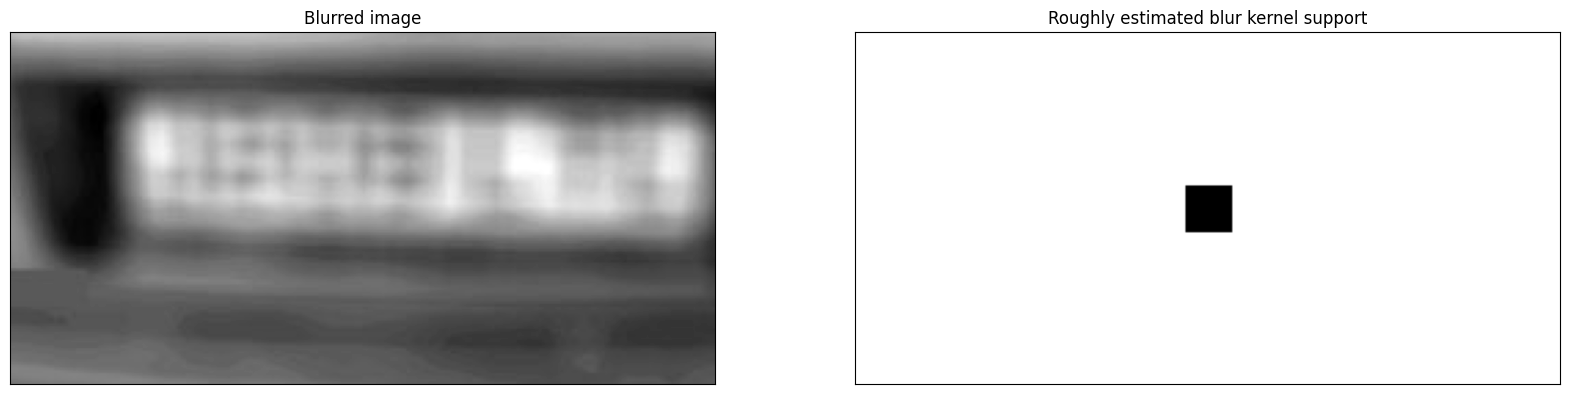

In [13]:
from lib.part1.deblur_lib import setup_show
setup_show()

###  Reformulating the problem

We now reformulate the blind image deconvolution problem, so that we can
apply the constrained optimization algorithms we have seen in the
course. Let ${\boldsymbol b}$ be the $L$-point normalized discrete
Fourier transform (DFT) of the observation $\textbf{y}$, i.e,
${\boldsymbol b}= \mathbf{F} \textbf{y}$, where $F$ is the DFT matrix.
Then, ${\boldsymbol b}$ can be written as
${\boldsymbol b}= {\boldsymbol A}({\bf X})$ where
${\bf X}= {\boldsymbol h}{\boldsymbol m}^\top$ and ${\boldsymbol A}$ is
a linear operator. Explicit expression of this linear operator
${\boldsymbol A}$ is out of the scope of this homework, c.f.,
[Ahmed2014](https://ieeexplore.ieee.org/document/6680763/) for further details. This reformulation allows us to
express $\textbf{y}$, which is a nonlinear combination of the
coefficients of ${\boldsymbol h}$ and ${\boldsymbol m}$, as a linear
combination of the entries of their outer product
${\bf X}= {\boldsymbol h}{\boldsymbol m}^\top$. Note that given
${\boldsymbol B}$ and ${\boldsymbol C}$, recovering ${\boldsymbol m}$
and ${\boldsymbol h}$ from ${\boldsymbol b}$ is the same as recovering
$\textbf{x}$ and ${\boldsymbol w}$ from $\textbf{y}$.

Since ${\bf X}$ is a rank one matrix, we can use the nuclear norm to
enforce approximately low-rank solutions. Then, we can formulate the
blind deconvolution problem as follows:
$$\begin{align}
{\boldsymbol X}^\star \in \arg \min_{ {\boldsymbol X}} \bigg\{ \frac{1}{2} \| \mathbf{A}({\boldsymbol X}) - {\boldsymbol b}\|_2^2 :  \| {\boldsymbol X}\|_\ast \leq \xi, ~{\boldsymbol X}\in \mathbb{R}^{p\times m}   \bigg\}, \tag{4}\label{eq:FWform}
\end{align}$$
where $\xi > 0$ is a tuning parameter.

Note that our problem is constrained to the nuclear norm ball
$\mathcal{X} = \{ {\boldsymbol X}: {\boldsymbol X}\in \mathbb{R}^{p \times m} , \| {\boldsymbol X}\|_\ast \leq \xi \}$.

We will apply the Frank-Wolfe algorithm to solve the optimization
problem given in \eqref{eq:FWform}. The Frank-Wolfe algorithm is one of the earliest
algorithms that avoids projections. Instead of projections, it leverages
lmos (for a very good survey see [Jaggi2013](https://proceedings.mlr.press/v28/jaggi13.html)):
$$\mathrm{lmo}(\nabla f ({\boldsymbol Z})) = \arg \min_{{\boldsymbol X}\in \mathcal{X}} ~ \langle \nabla f ({\boldsymbol Z}), {\boldsymbol X}\rangle,$$
where
$\mathcal{X} = \{ {\boldsymbol X}: \| {\boldsymbol X}\|_\ast \leq \xi, ~{\boldsymbol X}\in \mathbb{R}^{p\times m} \}$
as in Part 1. It applies to the generic constrained minimization
template with a smooth objective function,
$\min_{\boldsymbol X}\{ f({\boldsymbol X}) : {\boldsymbol X}\in \mathcal{X}, \, \mathcal{X} \text{ - convex, compact}  \}$
as follows:

----


### Frank-Wolfe's algorithm

1. Choose ${\boldsymbol X}^0 \in\mathcal{X}$.

2. For $k=0, 1, \ldots$ perform:
  $$\begin{cases}
  \hat{{\bf X}}^k &:= \mathrm{lmo}(\nabla f ({\boldsymbol X}^k)), \\
  {\bf X}^{k+1} &:= (1-\eta_k){\bf X}^k + \eta_k\hat{{\bf X}}^k,
  \end{cases}$$ where $\eta_k := {2}/{(k+2)}$

---



#### Question 1.4.1 (4 pts)

Recall that the Frank-Wolfe algorithm applies only for
    smooth objectives. Show that the objective function is smooth in the sense its gradient is Lipschitz continuous.

<font color="blue">
We have    
$$
   f(\mathbf{X}) = \frac{1}{2} \| \mathbf{A}(\mathbf{X}) - \mathbf{b} \|_2^2,
$$
   the gradient $ \nabla f(\mathbf{X}) $ is:

$$
   \nabla f(\mathbf{X}) = \mathbf{A}^T (\mathbf{A}(\mathbf{X}) - \mathbf{b}).
$$
where $ \mathbf{A} $ is the matrix which corresponds to the linear operator $\mathbf{A}(\mathbf{X})$ 
(we would name it **in the same way** for easier notation).
We thus have, as $ \mathbf{A} $ is linear operator,
$$
   \nabla f(\mathbf{X}) - \nabla f(\mathbf{Y}) = \mathbf{A}^T (\mathbf{A}(\mathbf{X}) - \mathbf{b}) - \mathbf{A}^T (\mathbf{A}(\mathbf{Y}) - \mathbf{b}) = \mathbf{A}^T \mathbf{A} (\mathbf{X} - \mathbf{Y}),
$$
$$
   \| \nabla f(\mathbf{X}) - \nabla f(\mathbf{Y}) \| = \| \mathbf{A}^T \mathbf{A} (\mathbf{X} - \mathbf{Y}) \|,
$$
so by the norm properties
$$
   \| \nabla f(\mathbf{X}) - \nabla f(\mathbf{Y}) \| \leq \| \mathbf{A}^T \mathbf{A} \| \cdot \| \mathbf{X} - \mathbf{Y} \|.
$$
Therefore, the Lipschitz constant is
$
   L = \| \mathbf{A} \|^2
$
and the objective function is indeed smooth.

### Implementation of Frank-Wolfe

Complete the missing lines of the Frank-Wolfe update below.
We provide you the linear operators that you need to compute the LMO in the code. Note that we do not need to
    store and use the linear operator ${\boldsymbol A}$ in the ambient
    dimensions. In fact, for storage and arithmetic efficiency, we
    should avoid explicitly writing ${\boldsymbol A}$. You can find more
    details about this aspect as comments in the code.

In [14]:
from lib.part1.deblur_lib import *

We will track three states:

- `X`: corresponding to $\boldsymbol X$
- `AX`: corresponding to $\boldsymbol{AX}$
- `k`: the iterate count

In [15]:
def init_state():
    return OptState(X=0.0, AX=0.0, k=1)

#### Question 1.4.2 (2 points) Complete the gradient computation of $f(\boldsymbol X)$
You have access to the following operators and variables:
    
- `A_T(Z)`: Computes $\boldsymbol A^\top \boldsymbol Z$ for some $\boldsymbol Z$.
- `Aoper`: Computes $\boldsymbol A \boldsymbol X$ for 1-rank matrix $\boldsymbol X$ using its SVD decomposition.
- `b`: corresponds to $\boldsymbol b$

**Remark**: The `grad` method will receive `AX` and not `X` for computational efficiency reasons.

In [16]:
f = Function(
    f = lambda AX: 0.5*np.linalg.norm(AX - b, 2)**2,
    grad = lambda AX: A_T(AX - b) # Fill
)

#### Question 1.4.3 (5 points) Complete the LMO

You are allowed to use `scipy`.

In [17]:
def lmo(Grad, xi=1000):
    """ This function implements the lmo operator.
    """

    # Fill
    topLe_vec, _, topRe_vec = svds(Grad, k=1)
    Xhat = -xi * np.outer(topLe_vec, topRe_vec)
    # Apply A to the rank 1 update
    # topLe_vec, _, topRe_vec = svds(Xhat, k=1)
    AXhat = Aoper(topLe_vec, -xi, topRe_vec.T)
    return (Xhat, AXhat)

#### Question 1.4.4 (5 points) Complete the Frank-Wolfe update

Fill in the missing update of `X` using the LMO from the previous exercise.

In [18]:
def state_update(f, state):
    X, AX, k = state

    Xhat, AXhat = lmo(f.grad(AX), xi=3000)

    # Step size
    eta_k = 2.0 / (k + 2)

    # Update X
    next_X = (1.0 - eta_k) * X + eta_k * Xhat

    # Update A*X
    next_AX = (1.0-eta_k)*AX + eta_k*(AXhat)

    return OptState(next_X, next_AX, k+1)
    

In [19]:
opt_algorithm = OptAlgorithm("FrankWolfe", init_state, state_update)

#### Question 1.4.5 (3 points) Run Frank-Wolfe

Tune the 
    parameter $\xi$ until the license plate number becomes readable.
    What is the license plate number? 


009 | 1.0762e+07:   3%|▎         | 7/201 [00:00<00:13, 14.44it/s]

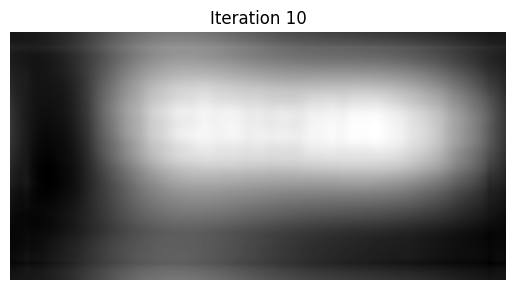

019 | 3.1391e+06:   8%|▊         | 17/201 [00:01<00:16, 11.20it/s]

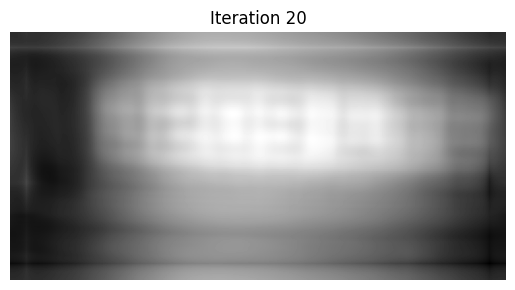

029 | 1.4924e+06:  13%|█▎        | 27/201 [00:02<00:14, 11.79it/s]

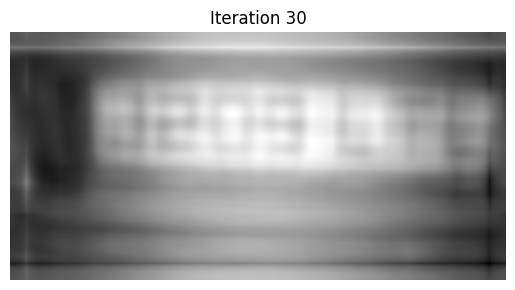

039 | 8.8067e+05:  18%|█▊        | 37/201 [00:04<00:15, 10.84it/s]

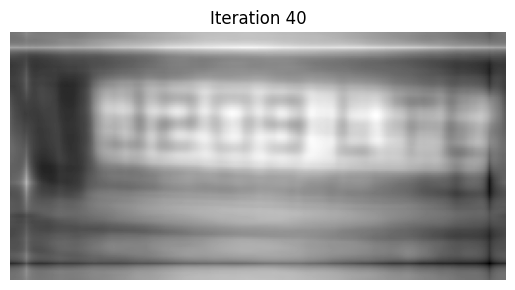

049 | 5.8680e+05:  23%|██▎       | 47/201 [00:05<00:14, 10.43it/s]

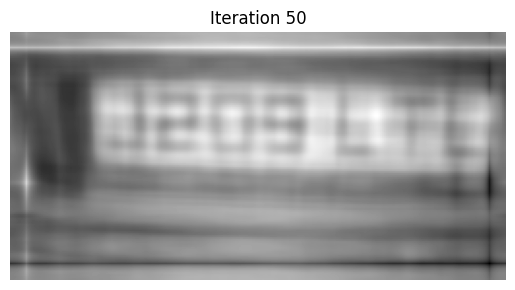

059 | 4.2259e+05:  28%|██▊       | 57/201 [00:06<00:12, 11.29it/s]

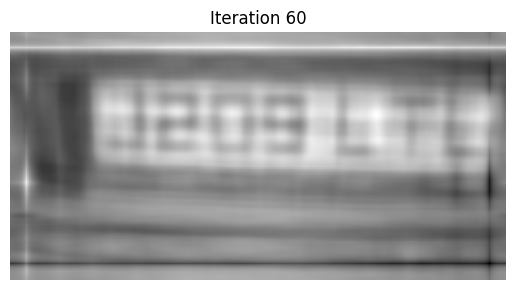

069 | 3.2120e+05:  33%|███▎      | 67/201 [00:07<00:11, 11.68it/s]

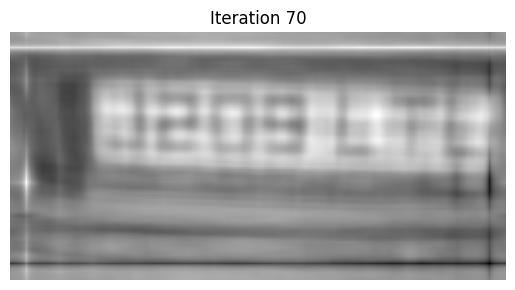

079 | 2.5400e+05:  38%|███▊      | 77/201 [00:09<00:10, 11.83it/s]

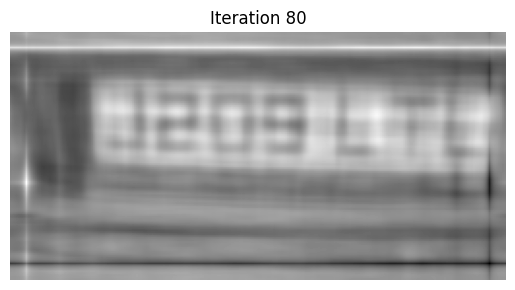

089 | 2.0703e+05:  43%|████▎     | 87/201 [00:10<00:09, 11.89it/s]

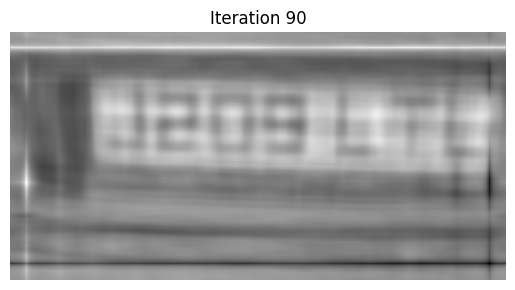

099 | 1.7283e+05:  48%|████▊     | 97/201 [00:11<00:08, 11.81it/s]

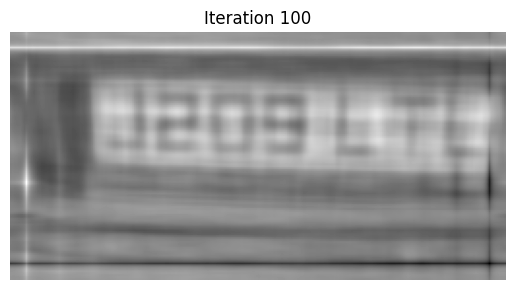

109 | 1.4710e+05:  53%|█████▎    | 107/201 [00:12<00:07, 11.89it/s]

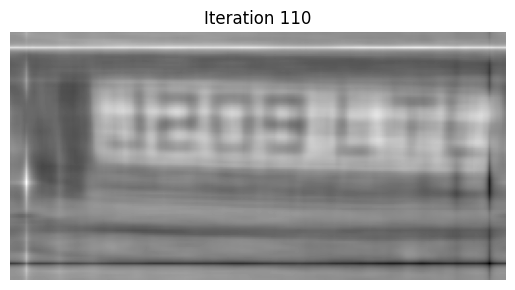

119 | 1.2720e+05:  58%|█████▊    | 117/201 [00:13<00:07, 11.79it/s]

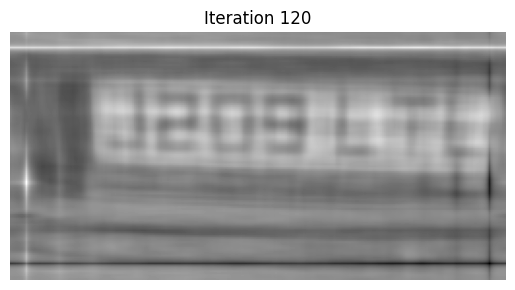

129 | 1.1147e+05:  63%|██████▎   | 127/201 [00:14<00:06, 11.82it/s]

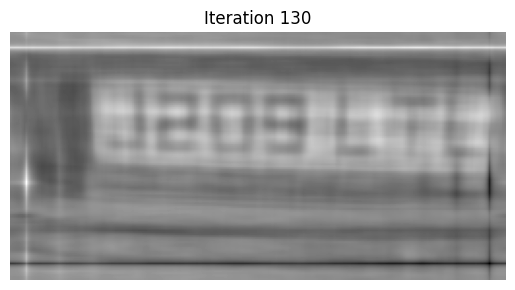

139 | 9.8802e+04:  68%|██████▊   | 137/201 [00:15<00:05, 11.94it/s]

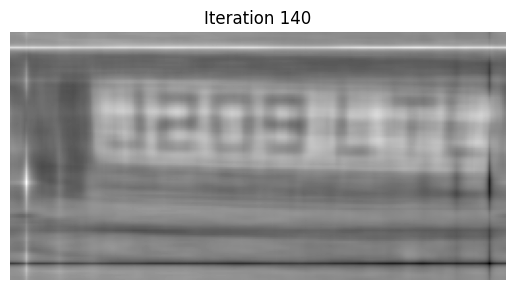

149 | 8.8429e+04:  73%|███████▎  | 147/201 [00:16<00:04, 11.43it/s]

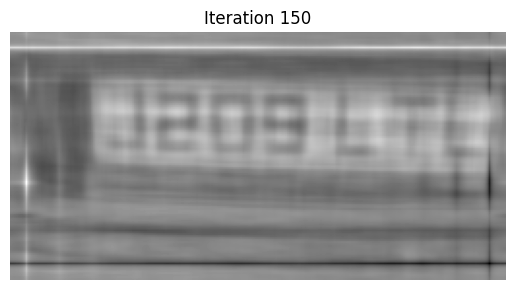

159 | 7.9818e+04:  78%|███████▊  | 157/201 [00:18<00:03, 11.86it/s]

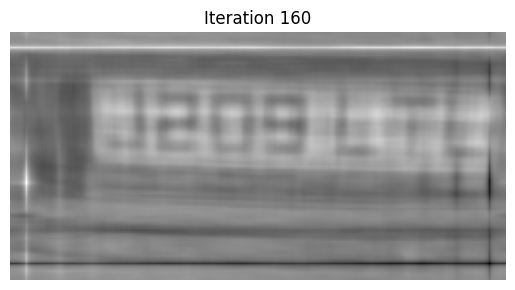

169 | 7.2580e+04:  83%|████████▎ | 167/201 [00:19<00:02, 11.75it/s]

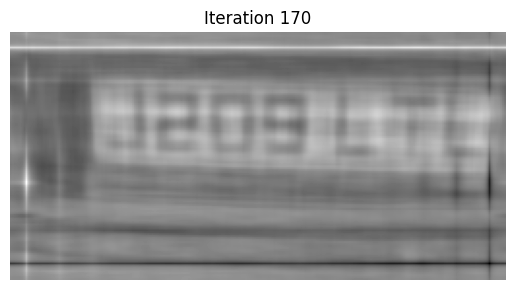

179 | 6.6431e+04:  88%|████████▊ | 177/201 [00:20<00:02, 11.86it/s]

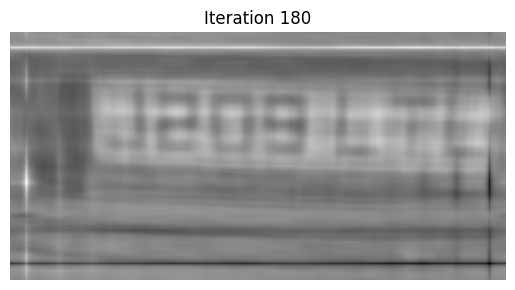

189 | 6.1156e+04:  93%|█████████▎| 187/201 [00:21<00:01, 11.57it/s]

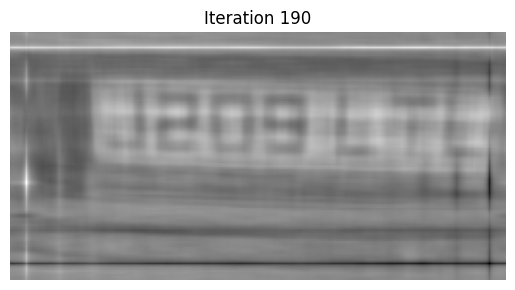

199 | 5.6593e+04:  98%|█████████▊| 197/201 [00:22<00:00, 11.85it/s]

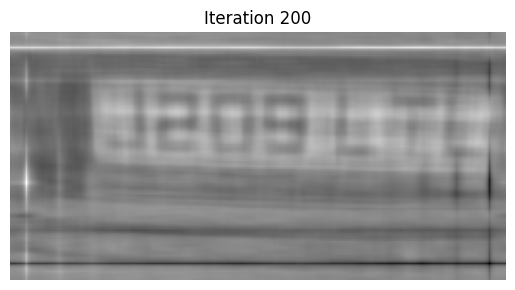

201 | 5.5754e+04: 100%|██████████| 201/201 [00:23<00:00,  8.63it/s]


In [20]:
# Run Frank-Wolfe's method
xFW = run_frank_wolfe(f, opt_algorithm)

<font color="blue">
    
J209LTL